Now that we have extracted features from our original dataset, we need to do some Exploratory Data Analysis (EDA) in order to asses the quality of the extracted features and decided we need to perform any of these:
- Feature Scaling
- Feature Transformation
- Feature Engineering

In [1]:
import sys
import os

repository_root_directory = os.path.dirname(os.getcwd())
rrd = "repository_root_directory:\t"
print(rrd, repository_root_directory)

if repository_root_directory not in sys.path:
    sys.path.append(repository_root_directory)
    print(rrd, "added to path")
else:  
    print(rrd, "already in path")

import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from utils import detect_outliers_iqr_and_plot

repository_root_directory:	 /teamspace/studios/this_studio/csc_461_fp
repository_root_directory:	 added to path


In [2]:
gtzan_features_path = '../_03_data_gtzan_features_labels.xlsx'      # Path to the GTZAN features file
gtzan_features_file = pd.ExcelFile(gtzan_features_path)             # Load the Excel file
gtzan_features_file.sheet_names                                     # See all sheet names               
sheet_data = gtzan_features_file.parse('Sheet1')                    # Load the data from the first sheet
sheet_data.head()                                                   # Display the first few rows: default is 5 rows                     


,RMS,ZCR,Spectral_Centroid,Spectral_Bandwidth,Spectral_Rolloff,MFCC_1,MFCC_2,MFCC_3,MFCC_4,MFCC_5,...,Chroma_4,Chroma_5,Chroma_6,Chroma_7,Chroma_8,Chroma_9,Chroma_10,Chroma_11,Chroma_12,Genre
0,0.147038,0.083045,1784.158246,2002.506999,3805.806298,-101.635178,121.570648,-19.162310,42.364071,-6.362351,...,0.244692,0.247862,0.335616,0.364619,0.435684,0.295985,0.315080,0.407008,0.385101,0
1,0.140256,0.056040,1530.406302,2039.316747,3550.946767,-170.173401,123.984703,8.947046,35.867355,2.909244,...,0.211472,0.200789,0.330795,0.397379,0.560356,0.384180,0.255326,0.284775,0.334094,0
2,0.206913,0.076291,1552.861222,1747.840170,3042.435096,-74.561050,140.440796,-29.084536,31.686720,-13.976517,...,0.407986,0.546820,0.321699,0.304657,0.288403,0.334152,0.401819,0.384389,0.588508,0
3,0.166737,0.033309,1070.285162,1596.858622,2185.012258,-183.127335,150.085907,5.663642,26.855532,1.769984,...,0.547012,0.657074,0.511523,0.355554,0.251613,0.246270,0.315112,0.316579,0.383199,0
4,0.106448,0.101461,1835.232440,1748.689585,3580.090700,-145.485397,126.209587,-35.580669,22.139540,-32.473171,...,0.255827,0.192664,0.530221,0.253779,0.139121,0.276424,0.324326,0.555123,0.272931,0


In [3]:
summary_stats_path = '../_04_summary_statistics_gtzan_features_labels.xlsx'     # Path to the summary statistics file
summary_stats_df = sheet_data.describe()                                           # Get the summary statistics of the data
summary_stats_df.to_excel(summary_stats_path)                                      # Save the summary statistics to an Excel file
summary_stats_excel = pd.ExcelFile(summary_stats_path)                                         # Load the Excel file
summary_stats_excel.sheet_names                                                                # See all sheet names
summary_stats_sheet1_df = summary_stats_excel.parse('Sheet1')                                                # Load the data from the first sheet
summary_stats_sheet1_df.set_index('Unnamed: 0', inplace=True)  # Set the first column as the index
num_rows = summary_stats_sheet1_df.shape[0]                                                   # Get the number of rows in the data
summary_stats_sheet1_df.head(num_rows)                                                        # Display all rows


,RMS,ZCR,Spectral_Centroid,Spectral_Bandwidth,Spectral_Rolloff,MFCC_1,MFCC_2,MFCC_3,MFCC_4,MFCC_5,...,Chroma_4,Chroma_5,Chroma_6,Chroma_7,Chroma_8,Chroma_9,Chroma_10,Chroma_11,Chroma_12,Genre
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.161560,0.103622,2202.096020,2242.955705,4572.221942,-113.223955,99.561455,-8.923417,36.293308,-1.147773,...,0.369945,0.387576,0.376572,0.359858,0.393662,0.378014,0.399160,0.375252,0.373526,4.500000
std,0.054685,0.041822,715.912318,526.169748,1574.656423,74.532234,31.318136,21.688811,16.662884,12.220969,...,0.115756,0.120663,0.111364,0.114492,0.115488,0.117619,0.118769,0.115107,0.115730,2.873719
min,0.040790,0.021697,570.751656,901.383563,749.698534,-367.956970,-1.471884,-89.864334,-18.756538,-38.909107,...,0.074952,0.070158,0.050617,0.082641,0.068351,0.061411,0.111275,0.061216,0.091698,0.000000
25%,0.122724,0.070244,1627.924292,1907.425928,3380.359000,-165.403584,76.779427,-24.217510,24.102556,-9.981031,...,0.288066,0.301770,0.296462,0.283999,0.314467,0.296855,0.313696,0.295076,0.292270,2.000000
50%,0.152158,0.099552,2212.359540,2223.835942,4660.751902,-99.173588,98.453869,-10.713522,36.950510,-0.021628,...,0.370238,0.383858,0.376933,0.356783,0.398414,0.376386,0.390894,0.371676,0.373652,4.500000
75%,0.193524,0.131944,2691.319263,2578.535843,5533.870830,-57.805912,119.944141,5.504158,48.195828,7.919895,...,0.444413,0.470693,0.451937,0.431359,0.470599,0.455930,0.482501,0.447758,0.444388,7.000000
max,0.397734,0.274631,4435.727333,3509.656096,8677.730976,42.098713,193.074478,56.647980,80.699188,31.427773,...,0.804350,0.809106,0.703145,0.803614,0.753515,0.776868,0.775460,0.802365,0.796879,9.000000


<Figure size 1800x800 with 0 Axes>

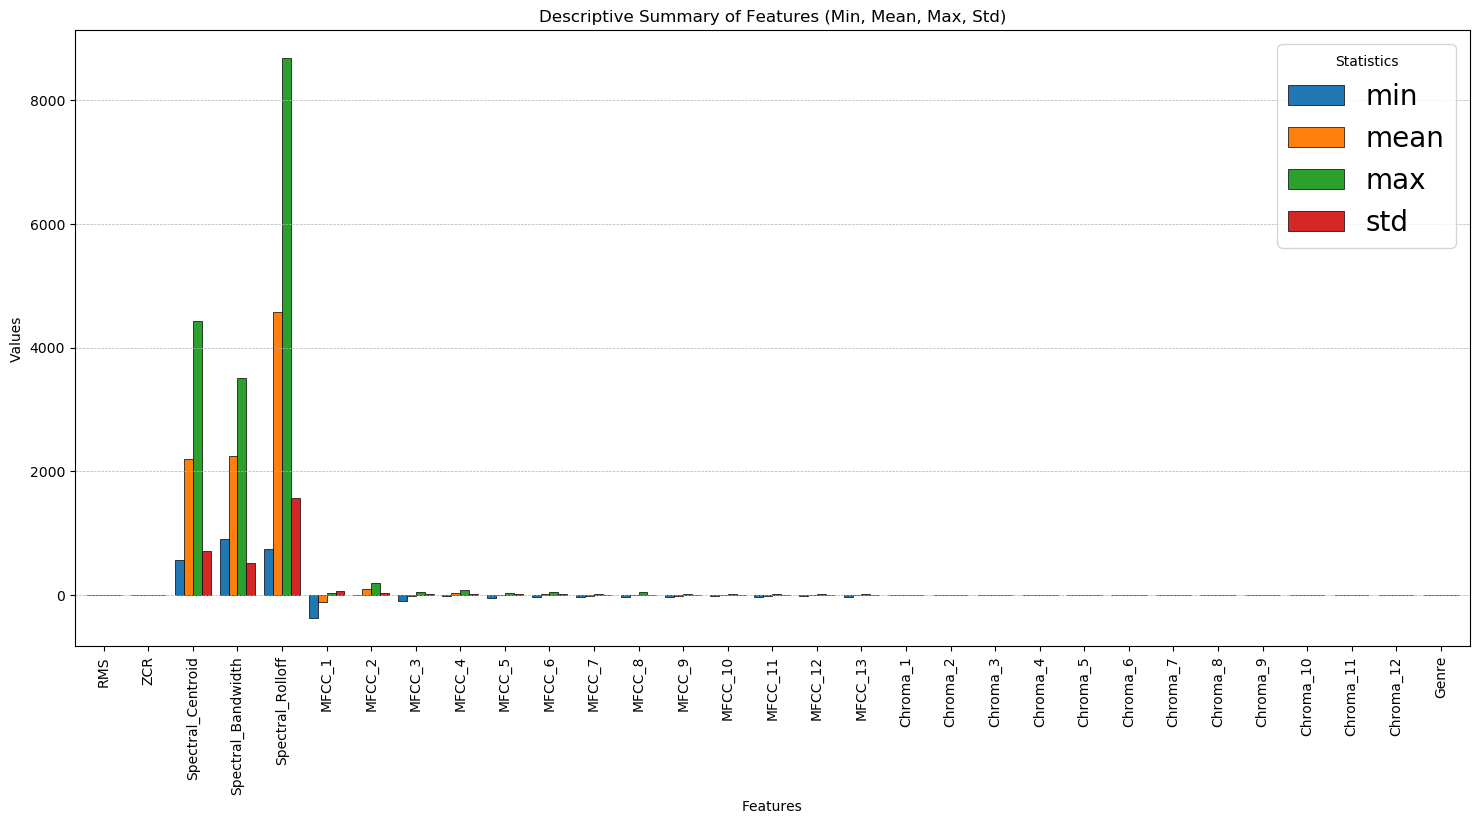

In [4]:
# Transpose the summary statistics DataFrame to make 'min', 'mean', 'max', and 'std' columns
summary_stats_to_plot = summary_stats_sheet1_df.T[['min', 'mean', 'max', 'std']]

# Plot the descriptive statistics with features on the x-axis
plt.figure(figsize=(18, 8))
summary_stats_to_plot.plot(kind='bar', figsize=(18, 8), width=0.8, edgecolor='black', linewidth=0.5)
plt.title("Descriptive Summary of Features (Min, Mean, Max, Std)")
plt.xlabel("Features")
plt.ylabel("Values")
plt.xticks(rotation=90, fontsize=10)
plt.legend(title="Statistics", fontsize=20)
plt.grid(axis='y', linestyle='--', linewidth=0.5)
#plt.tight_layout()
plt.show()



### Analysis of Descriptive Summary Plot

1. **Outliers**:
    - The presence of outliers can be inferred from the large range (min to max) in some features. The large range is definitely obvious in the plot for the spectral features. It is crucial to handle outliers before applying scaling techniques because: Outliers can skew the mean (for standardization) or the range (for normalization), leading to incorrect scaling, therefore affecting model performance. We can handle outliers by removal or capping.
    The plot suggest that some outliers might exist but we cannot confirm the existence of outliers just based on visual inspection: we need to apply techniques like Z-score and IQR (Inter Quartile Range) for outliers detection:
    https://medium.com/@ayeshasidhikha188/unveiling-outliers-exploring-z-score-and-iqr-methods-for-boxplots-67b0f3086720
    
    
2. **Feature Scaling**:
    - Features like `Spectral_Rolloff`, `Spectral_Centroid`, and `Spectral_Bandwidth` have significantly higher values compared to others. This indicates the need for feature scaling (normalization or standardization) to ensure that these features do not dominate the model training process. The spectral features show high variability (variance) which is confirmed by their high standard deviation. These features might dominate distance-based models like (k-NN, SVM) or gradient-based models if not scaled properly. Algorithms like SVM, k-NN, and neural networks are sensitive to the scale of input features. Ensuring that all features are on a similar scale can lead to better model performance and faster convergence during training.
    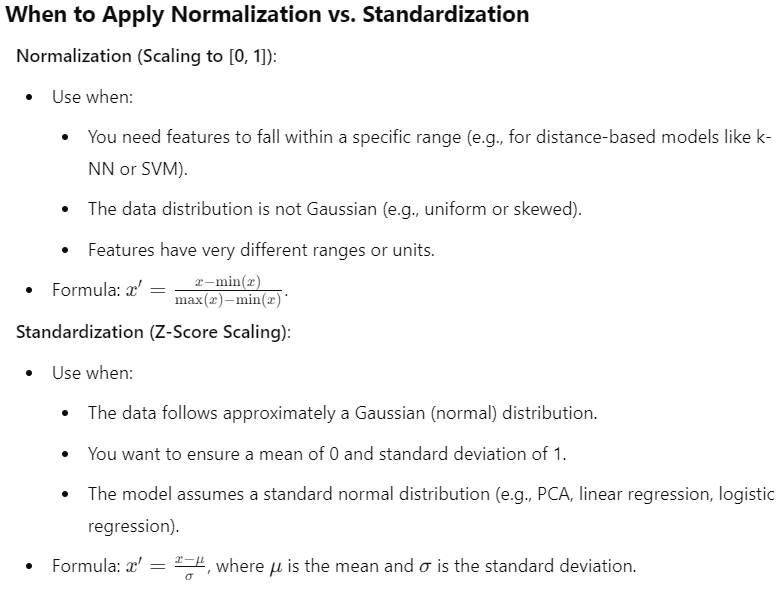


3. **Feature Importance - Random Forest**:
    - Consistent Features
    - Examples: Chroma features (e.g., Chroma_1 to Chroma_12).
    - Insights: These features have relatively small ranges and low standard deviations, indicating consistency across samples.
    - Implications: Consistent features might provide stable information for classification tasks, but low variability could    reduce their discriminative power.
    - Action: use Random Forest first to select the top features, then apply dimensionality reduction techniques (PCA, tsne) on the selected features, if dimension is of concern


Outliers detected for feature 'RMS':
200    0.320991
201    0.319285
207    0.320420
208    0.317861
473    0.303736
609    0.315284
752    0.321388
757    0.329241
762    0.397734
795    0.303593
886    0.350938
927    0.320465
Name: RMS, dtype: float64


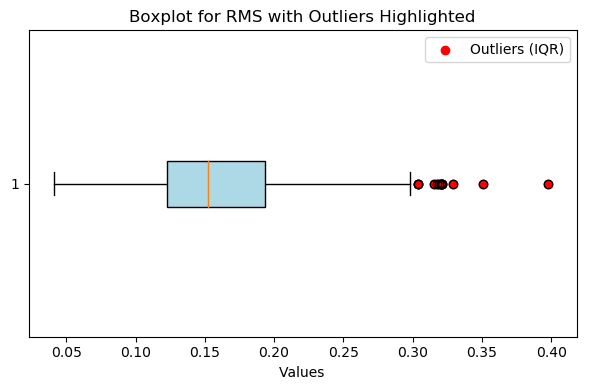

Outliers detected for feature 'ZCR':
586    0.261637
651    0.228380
732    0.228641
751    0.230096
851    0.274631
886    0.260148
Name: ZCR, dtype: float64


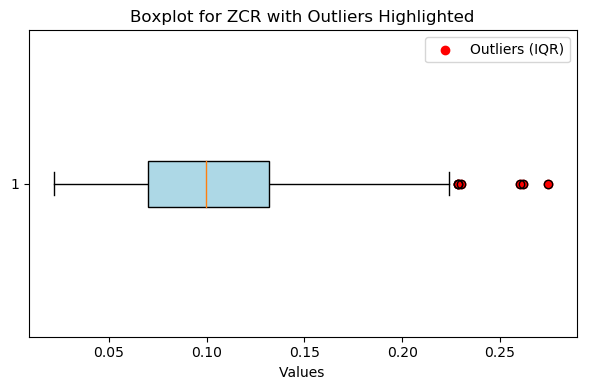

Outliers detected for feature 'Spectral_Centroid':
886    4435.727333
Name: Spectral_Centroid, dtype: float64


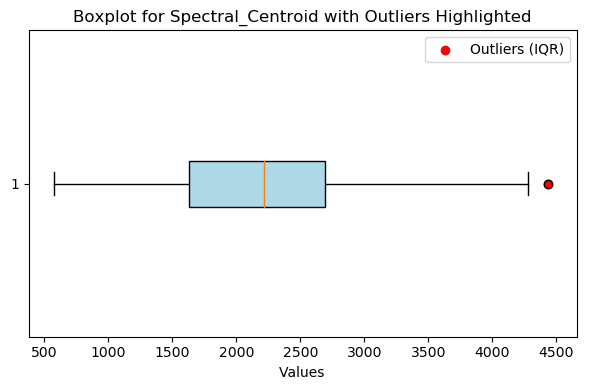

Outliers detected for feature 'MFCC_1':
89    -346.856354
93    -326.937073
164   -347.351166
166   -341.920868
167   -361.301056
177   -367.956970
Name: MFCC_1, dtype: float64


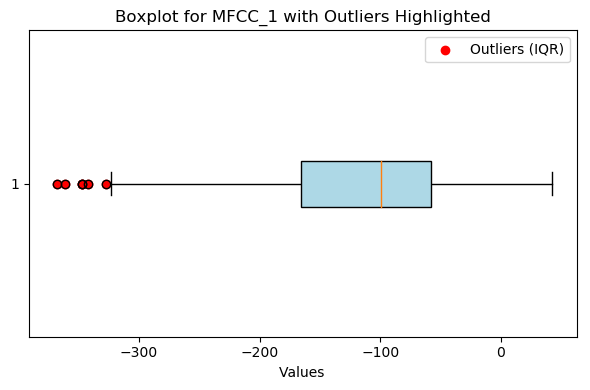

Outliers detected for feature 'MFCC_2':
183    190.142090
187    190.734299
503    193.074478
851     -1.471884
Name: MFCC_2, dtype: float64


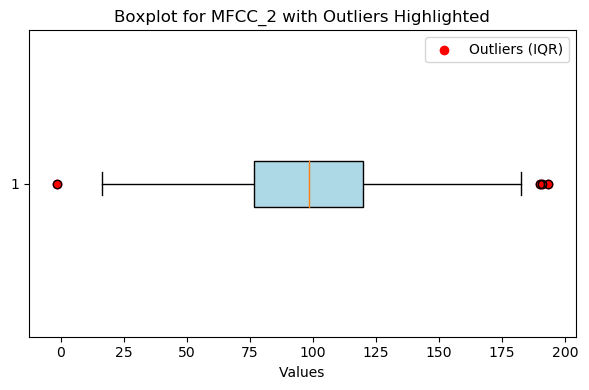

Outliers detected for feature 'MFCC_3':
163    56.647980
470    53.536579
618   -89.864334
713    53.263805
839    53.022961
Name: MFCC_3, dtype: float64


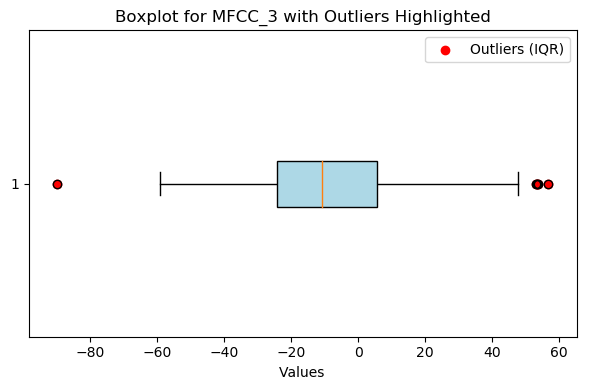

Outliers detected for feature 'MFCC_4':
753   -18.756538
Name: MFCC_4, dtype: float64


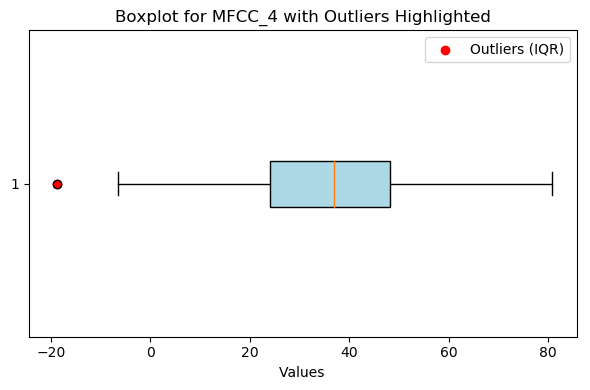

Outliers detected for feature 'MFCC_5':
69   -38.782970
72   -38.909107
Name: MFCC_5, dtype: float64


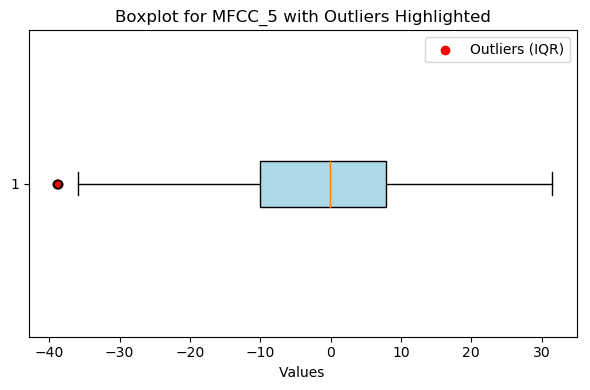

Outliers detected for feature 'MFCC_6':
753   -28.40494
Name: MFCC_6, dtype: float64


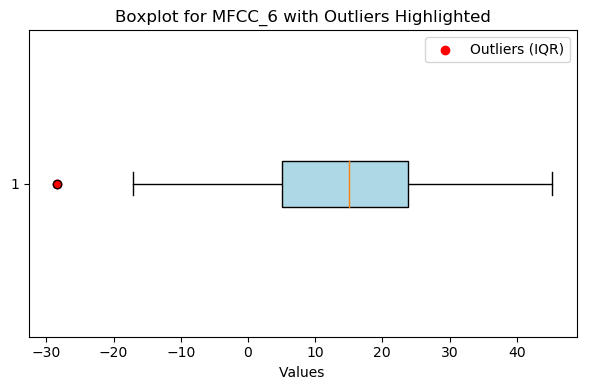

Outliers detected for feature 'MFCC_8':
189    49.018406
753   -24.918982
Name: MFCC_8, dtype: float64


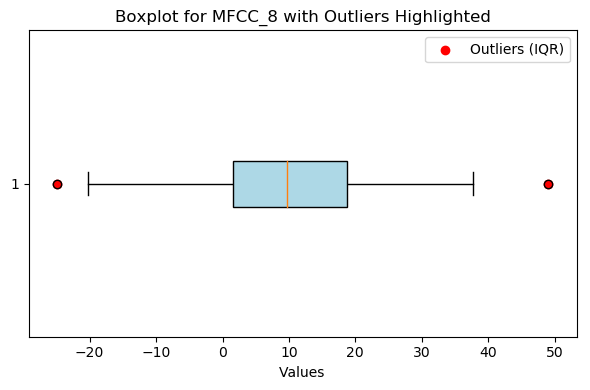

Outliers detected for feature 'MFCC_9':
189    19.131062
Name: MFCC_9, dtype: float64


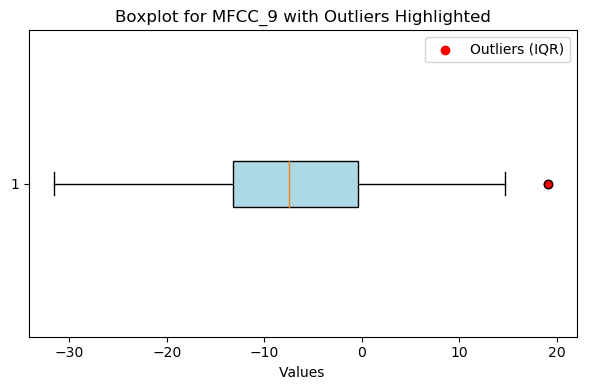

Outliers detected for feature 'MFCC_11':
31    -26.397512
33    -28.054605
869    17.418314
Name: MFCC_11, dtype: float64


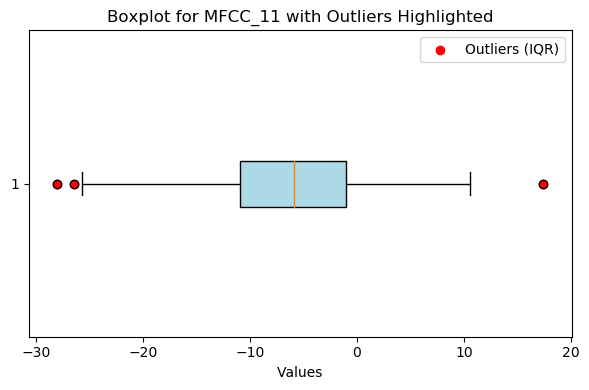

Outliers detected for feature 'MFCC_13':
72   -27.534193
Name: MFCC_13, dtype: float64


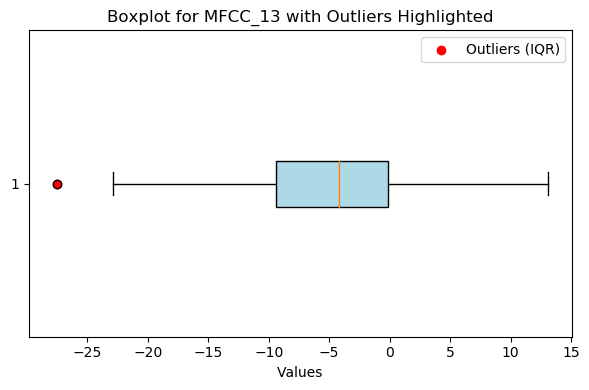

Outliers detected for feature 'Chroma_1':
230    0.047439
321    0.745549
394    0.700989
430    0.690017
481    0.707894
504    0.089356
953    0.786572
Name: Chroma_1, dtype: float64


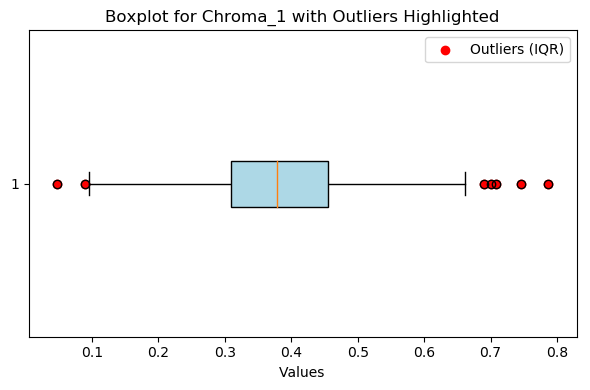

Outliers detected for feature 'Chroma_2':
132    0.700214
481    0.779378
618    0.715631
635    0.806371
648    0.767808
651    0.689379
674    0.744251
879    0.701480
884    0.709948
950    0.721885
Name: Chroma_2, dtype: float64


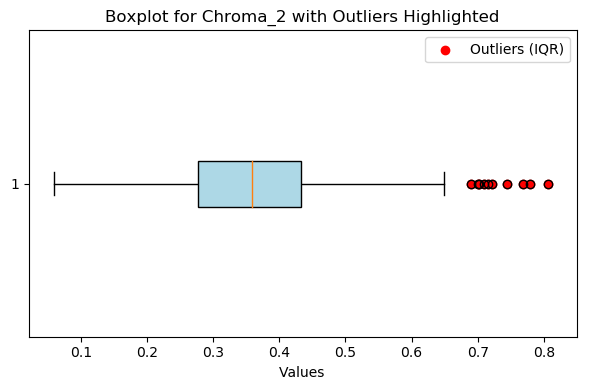

Outliers detected for feature 'Chroma_3':
175    0.068722
189    0.061193
192    0.042803
401    0.713041
587    0.698850
835    0.725715
886    0.729273
902    0.729707
995    0.773713
Name: Chroma_3, dtype: float64


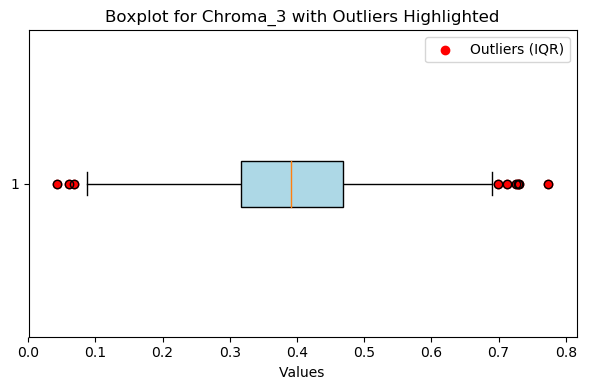

Outliers detected for feature 'Chroma_4':
215    0.760543
401    0.804350
442    0.761850
673    0.689380
920    0.706977
Name: Chroma_4, dtype: float64


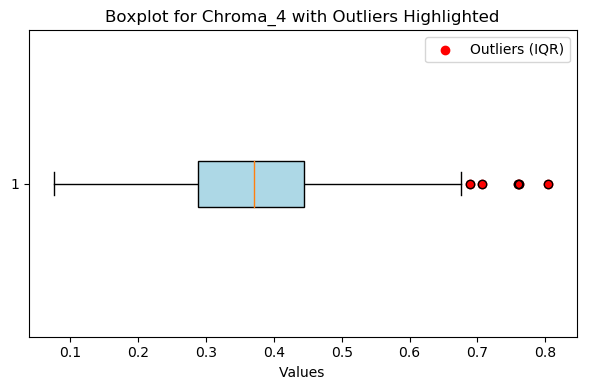

Outliers detected for feature 'Chroma_5':
625    0.809106
660    0.738459
676    0.777271
956    0.773539
Name: Chroma_5, dtype: float64


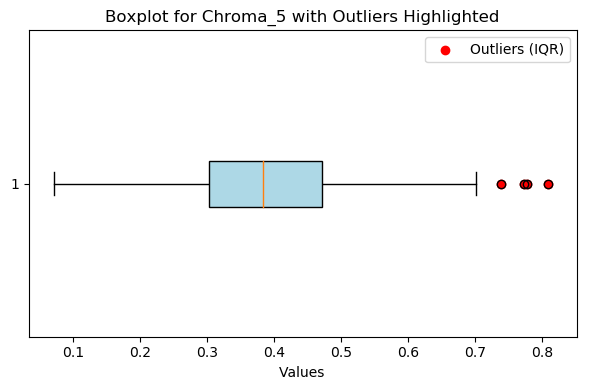

Outliers detected for feature 'Chroma_6':
116    0.050617
164    0.056816
459    0.685774
613    0.702105
886    0.703145
Name: Chroma_6, dtype: float64


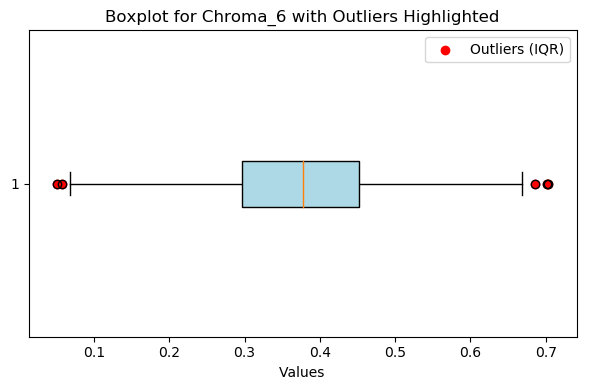

Outliers detected for feature 'Chroma_7':
337    0.740522
365    0.682411
681    0.756576
836    0.696739
862    0.684890
949    0.680643
993    0.698325
994    0.803614
Name: Chroma_7, dtype: float64


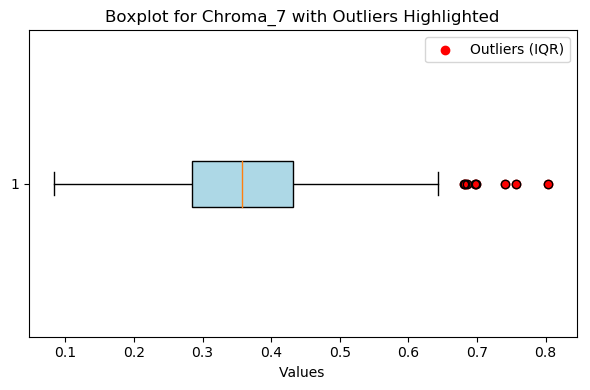

Outliers detected for feature 'Chroma_8':
189    0.075254
192    0.068351
209    0.753515
703    0.710503
Name: Chroma_8, dtype: float64


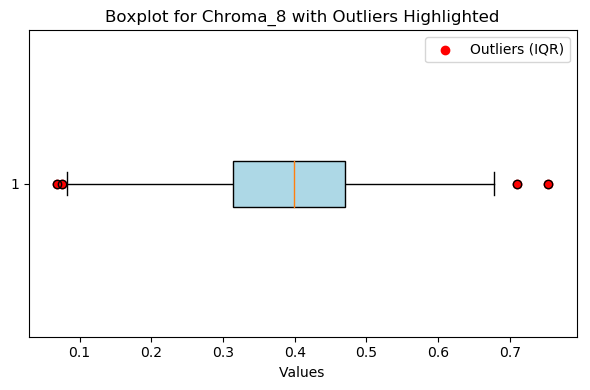

Outliers detected for feature 'Chroma_9':
414    0.776868
604    0.698149
613    0.699822
675    0.711401
Name: Chroma_9, dtype: float64


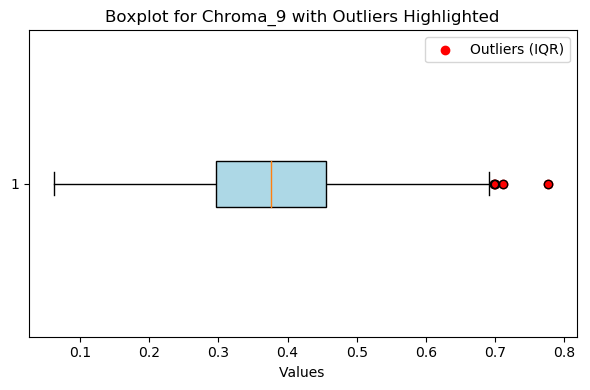

Outliers detected for feature 'Chroma_10':
435    0.755675
659    0.775460
Name: Chroma_10, dtype: float64


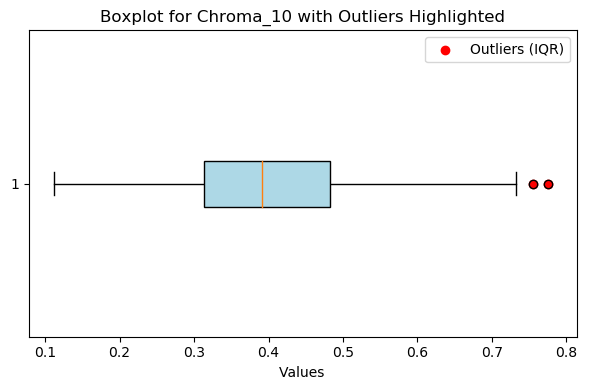

Outliers detected for feature 'Chroma_11':
13     0.691769
25     0.776088
193    0.061216
303    0.695208
397    0.802365
435    0.717462
886    0.732455
Name: Chroma_11, dtype: float64


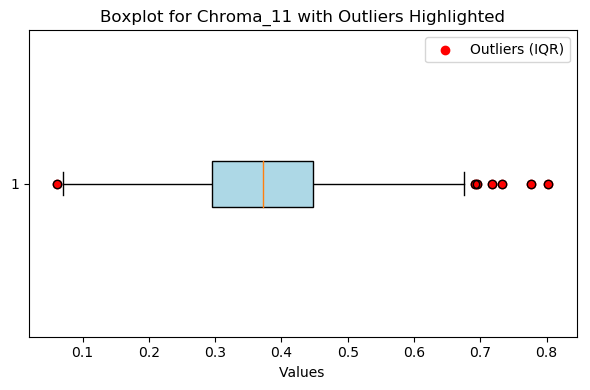

Outliers detected for feature 'Chroma_12':
633    0.686084
657    0.682505
851    0.775291
880    0.695794
881    0.721287
882    0.721287
886    0.796879
935    0.689430
Name: Chroma_12, dtype: float64


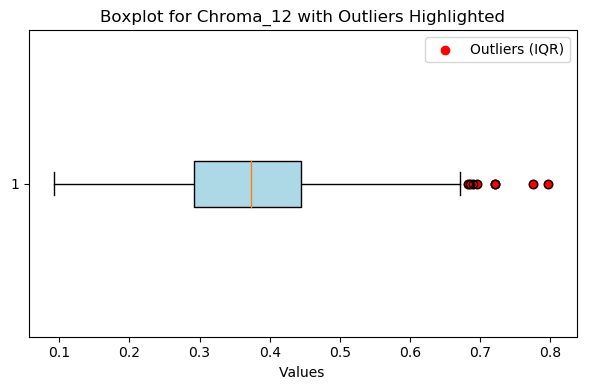

In [5]:
# Outliers detection
detect_outliers_iqr_and_plot(sheet_data, summary_stats_sheet1_df, 'genre')


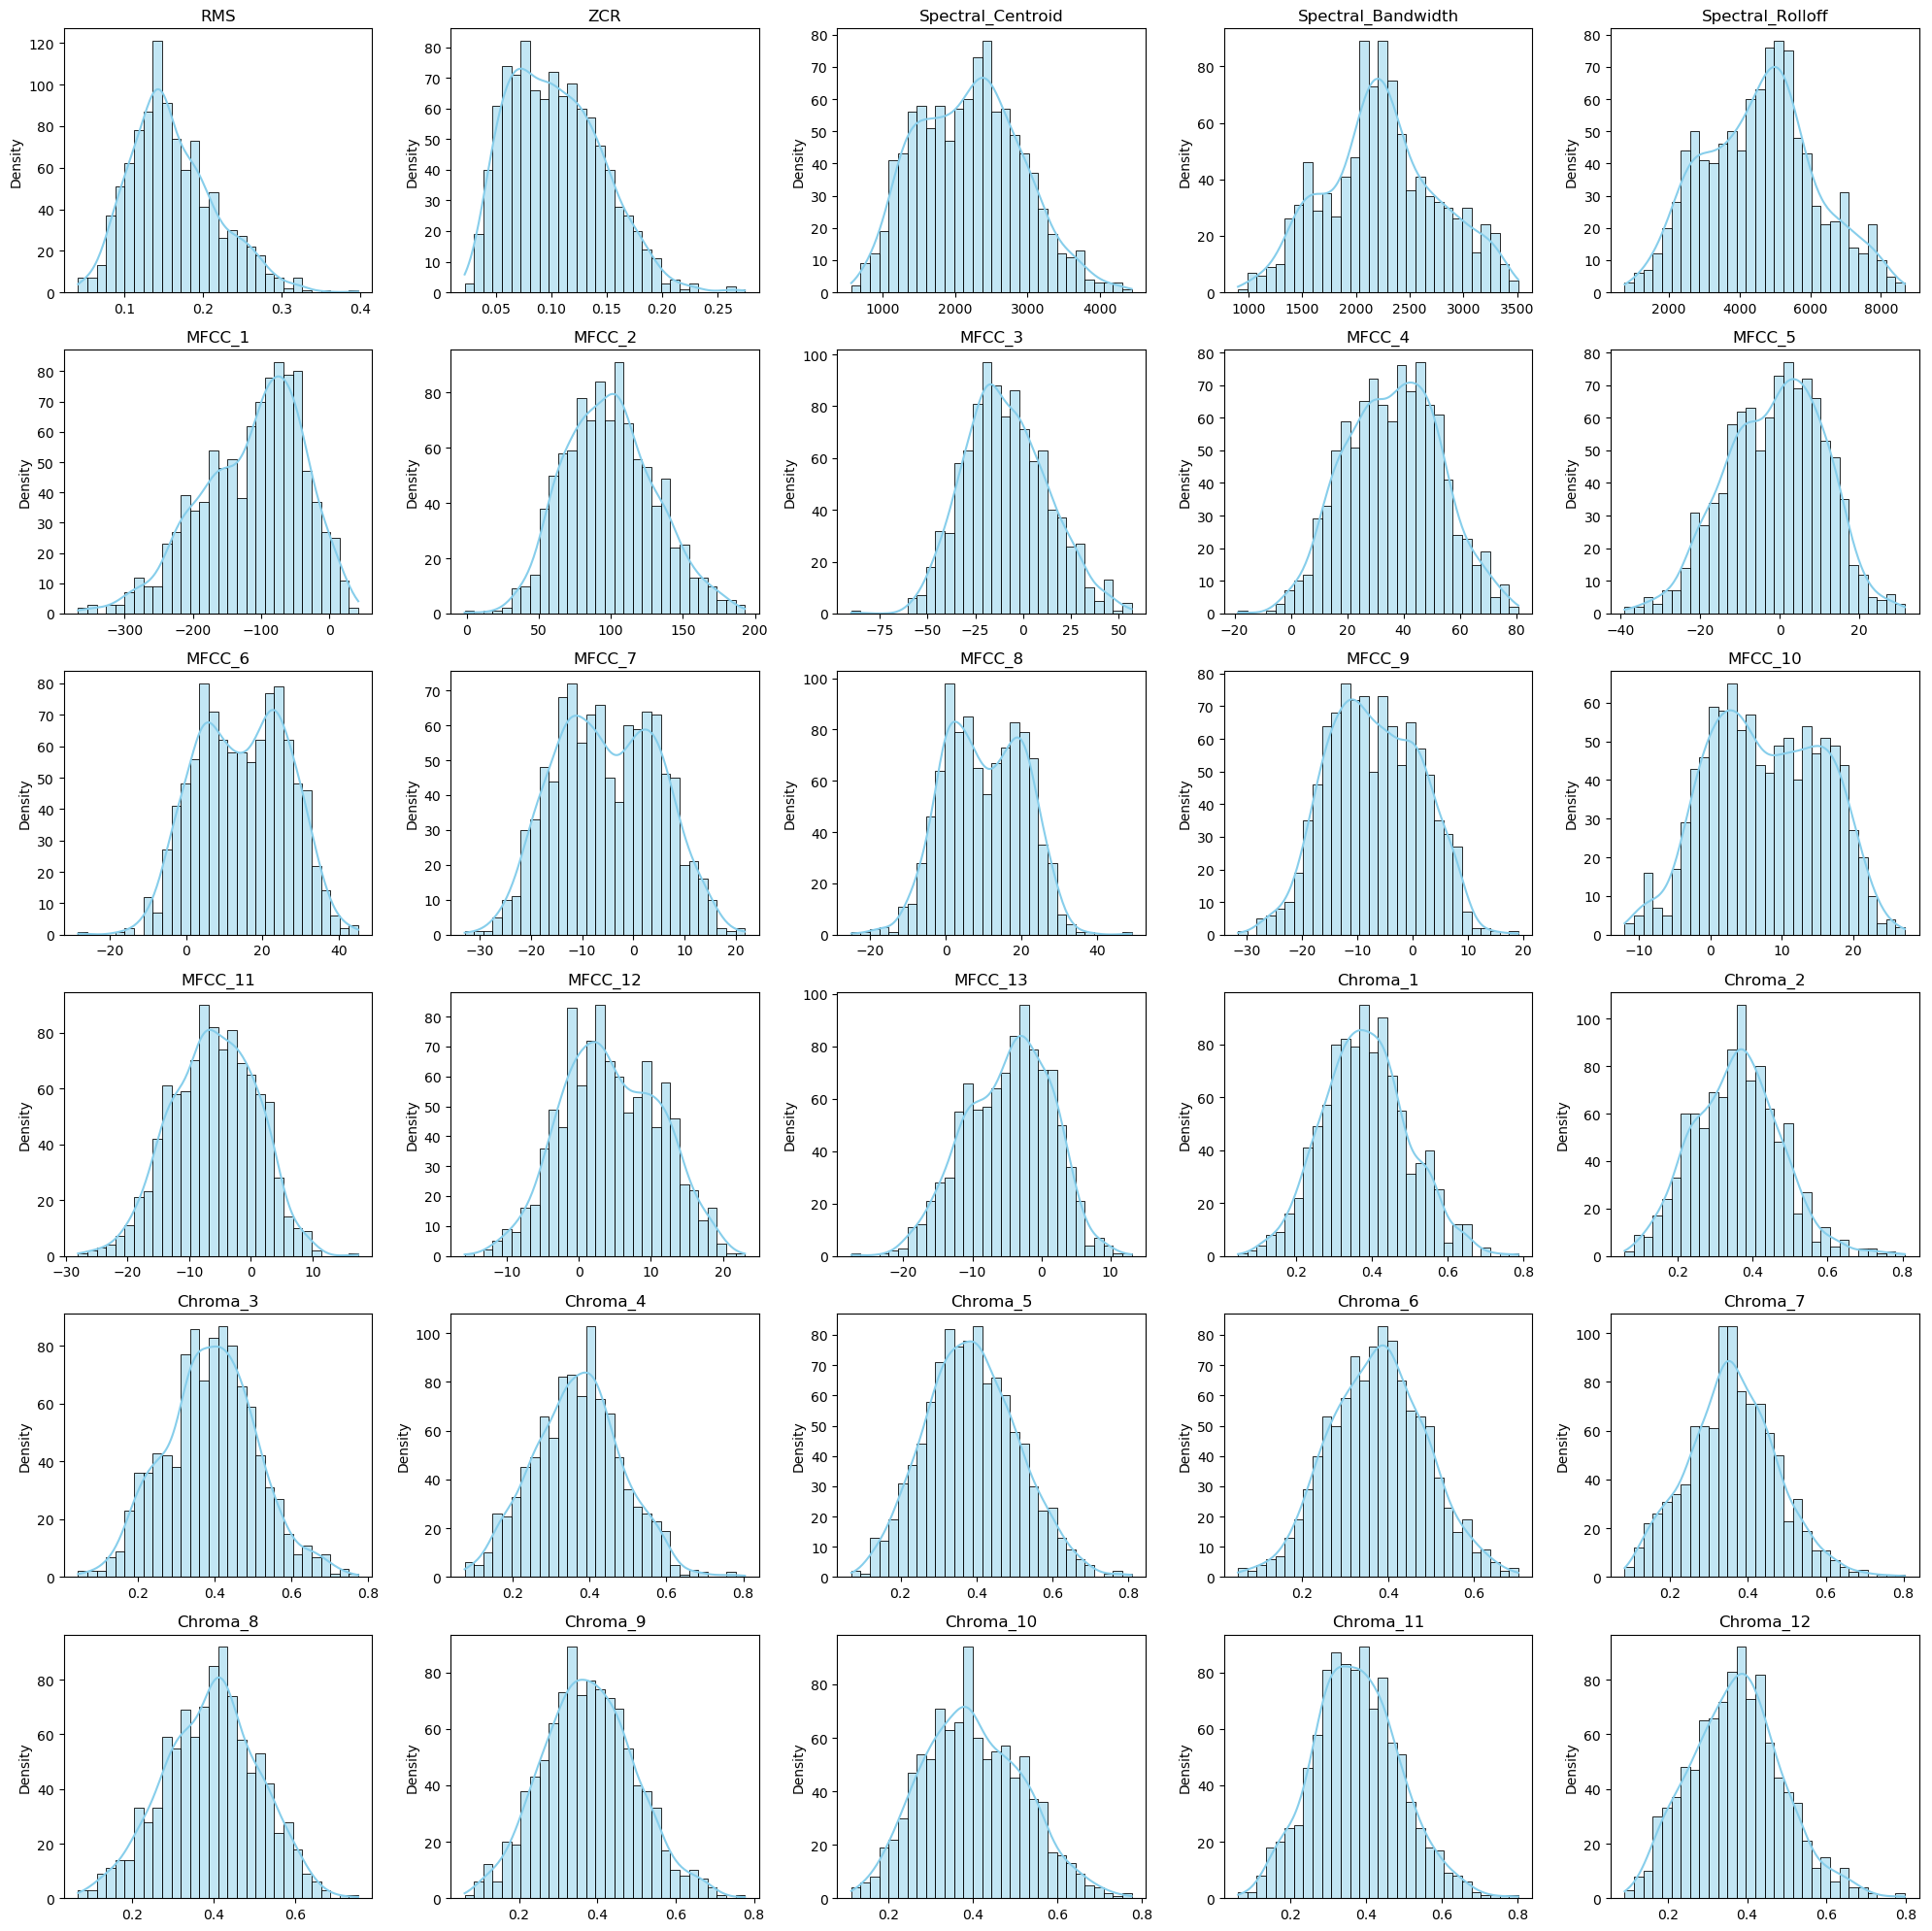

In [6]:
# visualize the distributions of each feature
num_features = len(sheet_data.columns) - 1  # Exclude the 'Genre' column
cols = 5  # Number of columns in the grid
rows = (num_features // cols) + (num_features % cols > 0)  # Calculate rows needed

plt.figure(figsize=(20, 20))
for i, feature in enumerate(sheet_data.columns[:-1], 1):  # Exclude 'Genre'
    plt.subplot(rows, cols, i)
    sns.histplot(sheet_data[feature], kde=True, bins=30, color='skyblue')
    plt.title(feature)
    plt.xlabel("")
    plt.ylabel("Density")

plt.tight_layout()
plt.show()
